In [80]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
from scipy.optimize import minimize
from sklearn.model_selection import GridSearchCV

class WeatherModel():
    def __init__(self, filename):
        self.data = pd.read_csv(filename)
        self.data = self.data.drop(columns=['GUST', 'SNDP', 'STP'])
        self.data = self.data.replace(999.9, pd.NA)
        self.data = self.data.replace(9999.9, pd.NA)
        self.data['PRCP'] = self.data['PRCP'].replace(99.99, pd.NA)
        self.data['DATE'] = pd.to_datetime(self.data['DATE'])
        self.data = self.data[~((self.data['DATE'].dt.month == 2) & (self.data['DATE'].dt.day == 29))]
        self.data = self.data.ffill()

        self.seasonal = None
        self.residuals = None

        self.year_data = self.get_year_data()
        self.arma_models = []

    def get_year_data(self):
        data = self.data[["MAX", "MIN", "TEMP", "MXSPD", "PRCP", "SLP", "DEWP", "WDSP"]]
        data = data.to_numpy()

        drop_rows = data.shape[0] % 365
        data = data[:-drop_rows]

        data = data.reshape(-1, 365, data.shape[1])

        return data

    def get_seasonal_trend(self):
        
        seasonal = np.mean(self.year_data, axis=0)
        self.seasonal = seasonal

        return seasonal
    
    def get_residuals(self):
        
        if self.seasonal is None:
            self.get_seasonal_trend()

        residuals = self.year_data - self.seasonal
        residuals = residuals.reshape(-1, residuals.shape[2])
        self.residuals = residuals

        return residuals
    
    def fit_arma(self, order, train_stop = None):

        if train_stop is None:

            if self.residuals is None:
                self.get_residuals()

            arma_models = []

            pbar = tqdm(total=self.residuals.shape[1])

            for i in range(self.residuals.shape[1]):
                pbar.set_description(f"Fitting {i+1}/{self.residuals.shape[1]} ARMA models")
                pbar.update(1)
                model = ARIMA(self.residuals[:, i], order=order)
                model_fit = model.fit()
                arma_models.append(model_fit)
                
            self.arma_models = arma_models

            return None
        else:

            if self.residuals is None:
                self.get_residuals()

            arma_models = []
            #print(self.residuals[train_stop,:].shape[1])
            pbar = tqdm(total=self.residuals[:train_stop,:].shape[1])
            for i in range(self.residuals[:train_stop,:].shape[1]):
                pbar.set_description(f"Fitting {i+1}/{self.residuals.shape[1]} ARMA models")
                pbar.update(1)
                model = ARIMA(self.residuals[:train_stop, i], order=order)
                model_fit = model.fit()
                arma_models.append(model_fit)
                
            self.arma_models = arma_models

            return None

    
    def fit(self, p,q, train_stop = None):
        self.fit_arma(order = (p,0,q), train_stop = train_stop)
        return None

    # def Grid(self):
    #     dict_for_GS = dict()
    #     dict_for_GS[p0] = [0,1,2,3,4,5,6,7]
    #     dict_for_GS[q0] = [0,1,2,3,4,5,6,7]
    #     GS = GridSearchCV(wm.fit, dict_for_GS, n_jobs = -1)
    #     GS.f=best_score
    #     wm.fit(1,0,1)
    #     models = wm.arma_models
    
    def predict(self, start=0, future=0):
        if len(self.arma_models) == 0:
            raise ValueError("Model not fitted yet")

        arma_predictions = np.array([model.predict(start=start, end=len(self.residuals) - start + future) for model in self.arma_models])

        season_start = start % 365
                
        num_stacks = arma_predictions.shape[1] // self.seasonal.shape[0]
        num_extras = arma_predictions.shape[1] % self.seasonal.shape[0]


        seasonal_predictions = np.vstack([self.seasonal for _ in range(num_stacks)])
        print("Seasonal Predictions", seasonal_predictions.shape)
        print("Residual shape", arma_predictions.shape)
        print("Num stacks", num_stacks)
        print("Num extras", num_extras)

        if num_extras > 0:
            seasonal_predictions = np.vstack((seasonal_predictions, self.seasonal[:num_extras].reshape(num_extras, -1)))



        return seasonal_predictions.T + arma_predictions
    



In [81]:
wm = WeatherModel('3968119.csv')

#Defining score for model
def score(model):
    return ([model[i].aic for i in range(len(model))])

# dict_for_GS = dict()
# dict_for_GS["p0"] = [0,1,2,3,4,5,6,7]
# dict_for_GS["q0"] = [0,1,2,3,4,5,6,7]
# GS = GridSearchCV(wm, dict_for_GS, n_jobs = -1, scoring = score)
# GS.fit(wm.data)
# #GS.f = best_score
# models = wm.arma_models

#Making values to look over
p0 = [1,2,3,4,5,6,7]
q0 = [1,2,3,4,5,6,7]
best_scores = dict()
iter = 0
for p in p0:
    for q in q0:
        #Looping through p and q
        wm.fit(p,q,train_stop = int(len(wm.data)*.8))
        models = wm.arma_models
        scores = score(models)
        #Scoring and finding best score
        for i in range(len(scores)):
            if iter == 0:
                best_scores[i] = [scores[i],p,q]
        else:
            if best_scores[i][0] > scores[i]:
                best_scores[i] = [scores[i],p,q]
        iter += 1
print(best_scores)

  0%|          | 0/8 [00:00<?, ?it/s]














Fitting 8/8 ARMA models: 100%|██████████| 8/8 [00:03<00:00,  2.36it/s]
















Fitting 8/8 ARMA models: 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]
















Fitting 8/8 ARMA models: 100%|██████████| 8/8 [00:08<00:00,  1.06s/it]
















Fitting 1/8 ARMA models:   0%|          | 0/8 [00:00<?, ?it/s]/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
Fitting 4/8 ARMA models:  50%|█████     | 4/8 [00:03<00:03,  1.02it/s]

In [ ]:
predictions = wm.predict(start=0, future=365*10)

Seasonal Predictions (12045, 8)
Residual shape (8, 12046)
Num stacks 33
Num extras 1


(8, 12046)
(8, 8395)


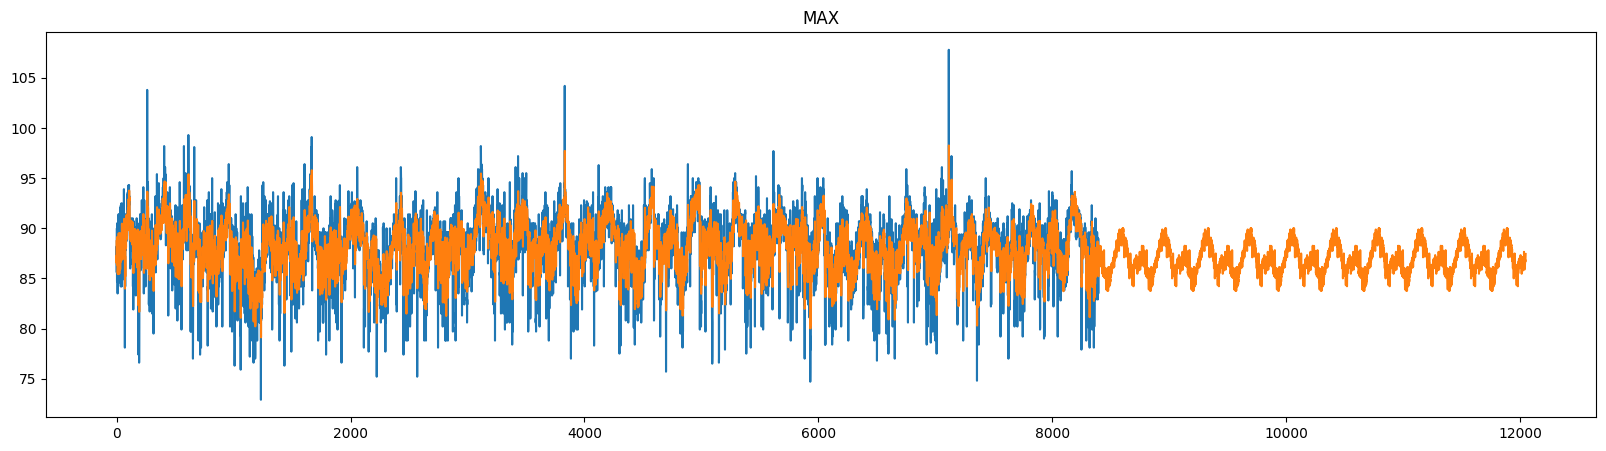

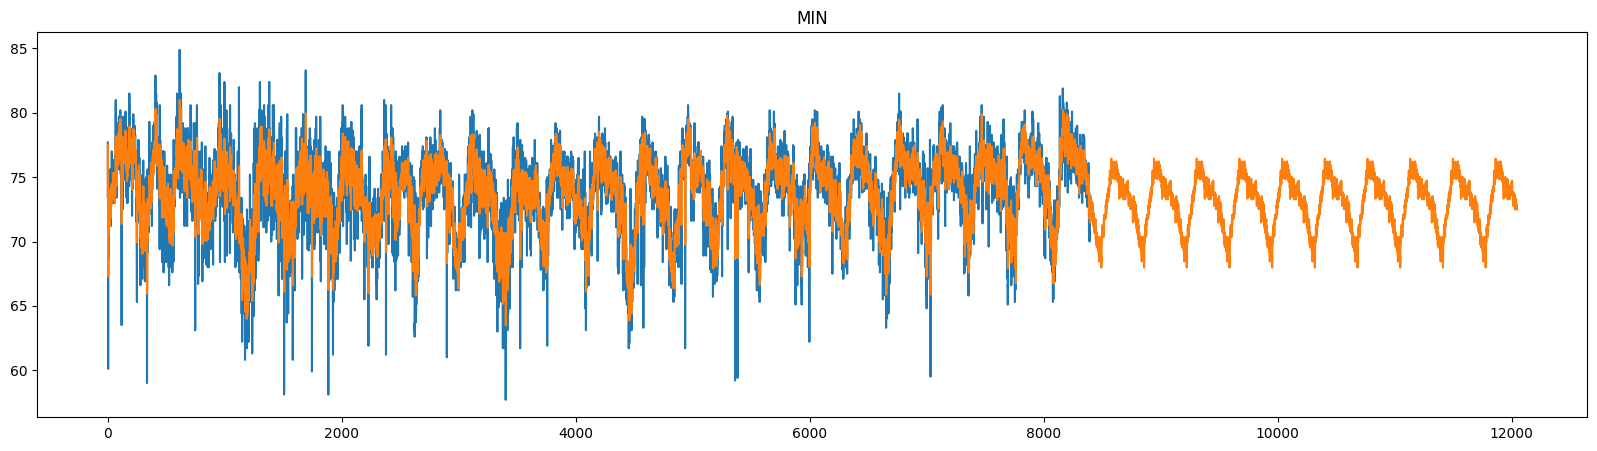

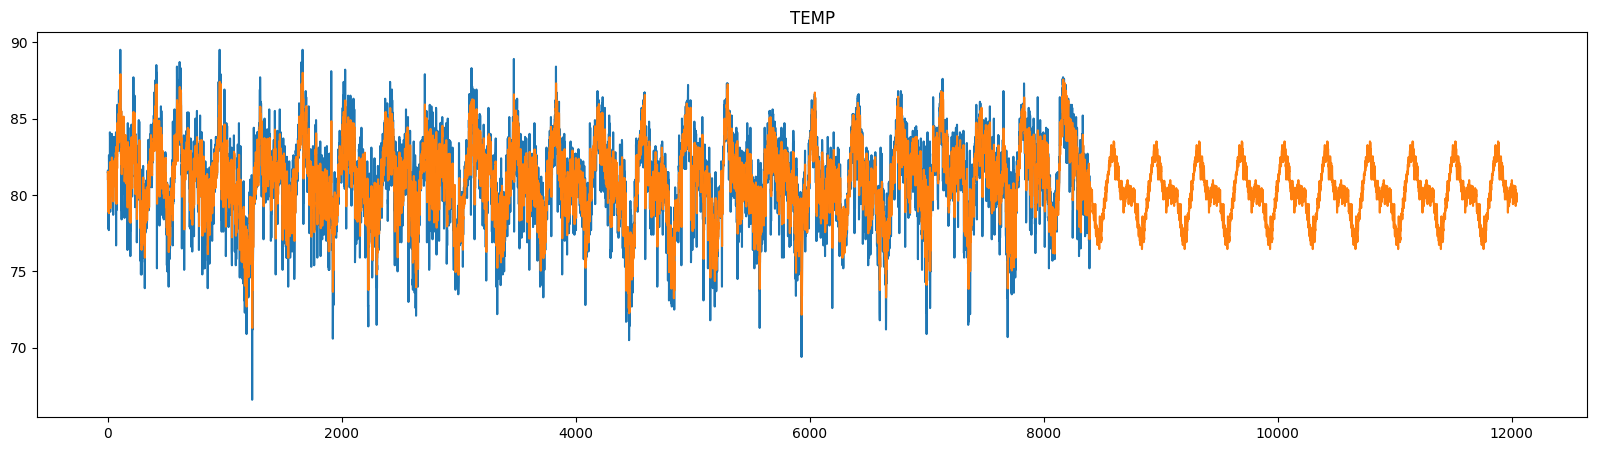

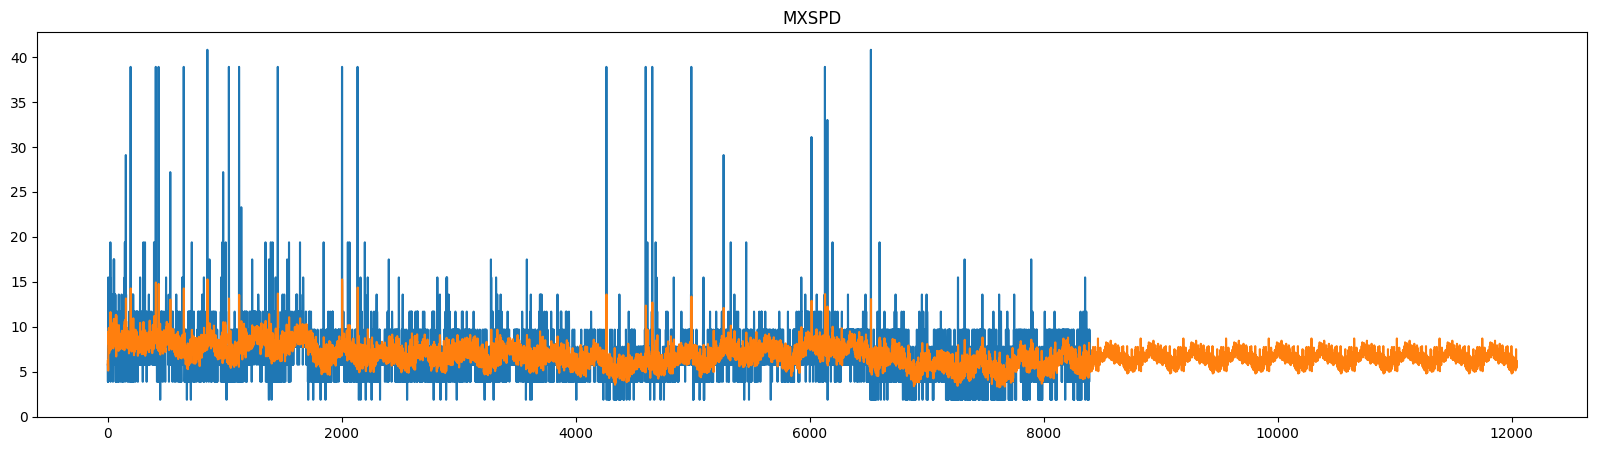

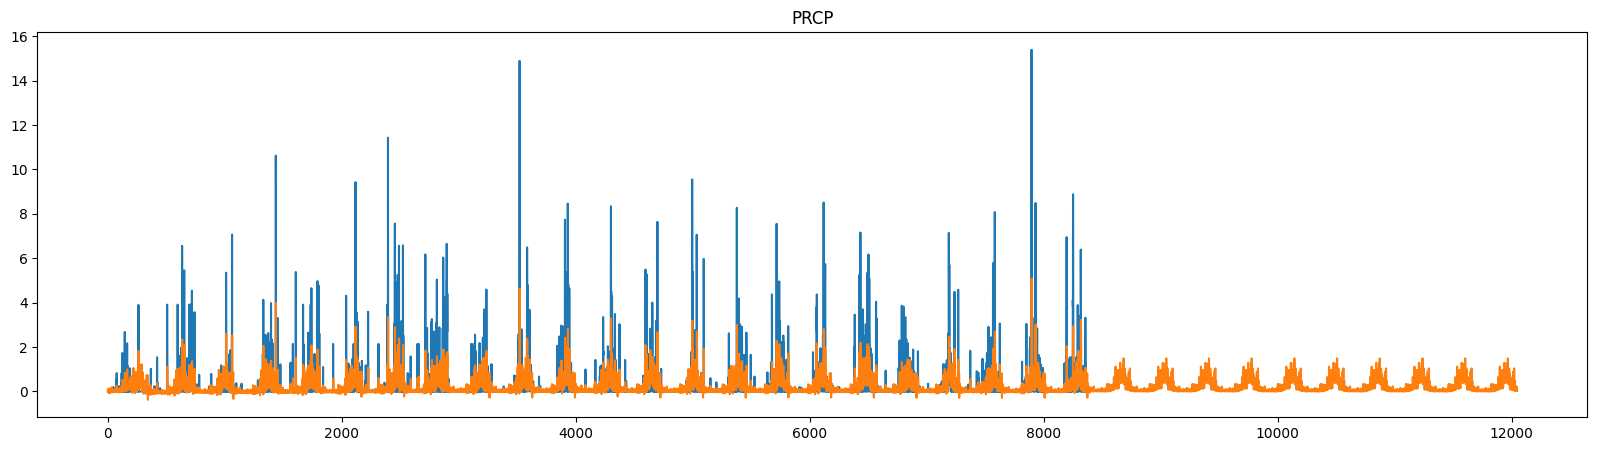

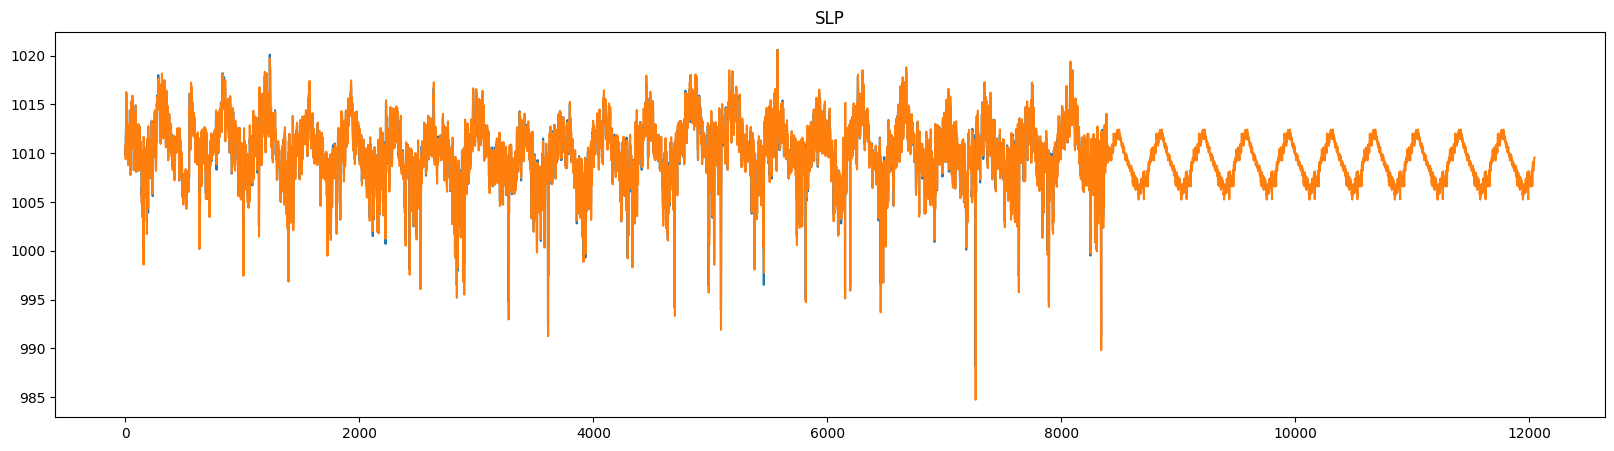

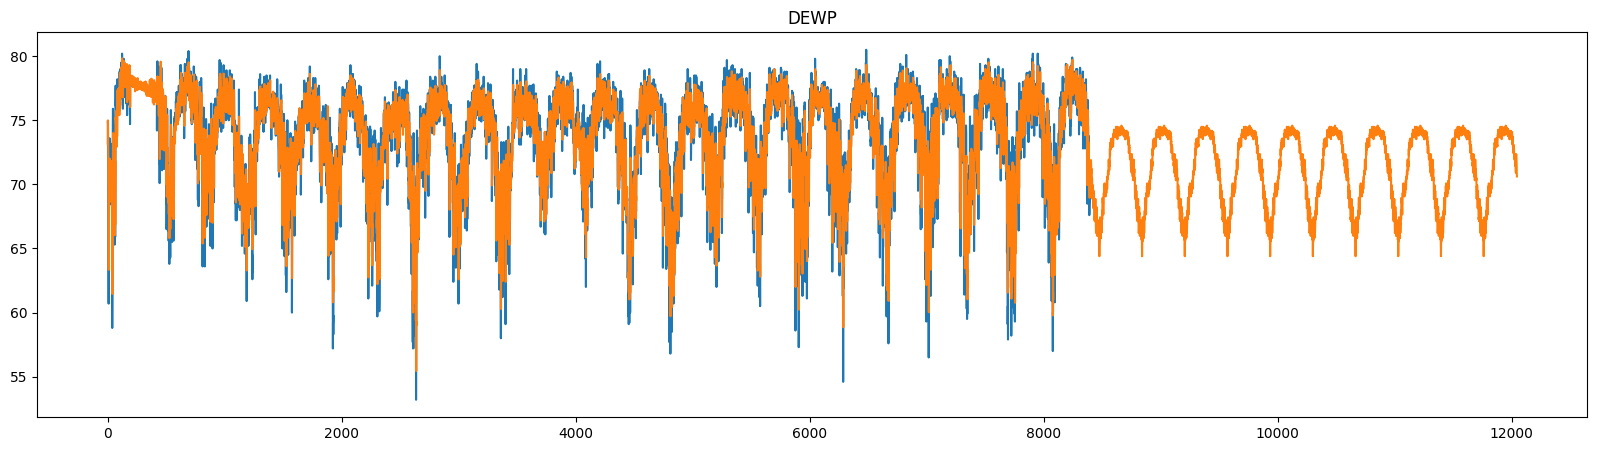

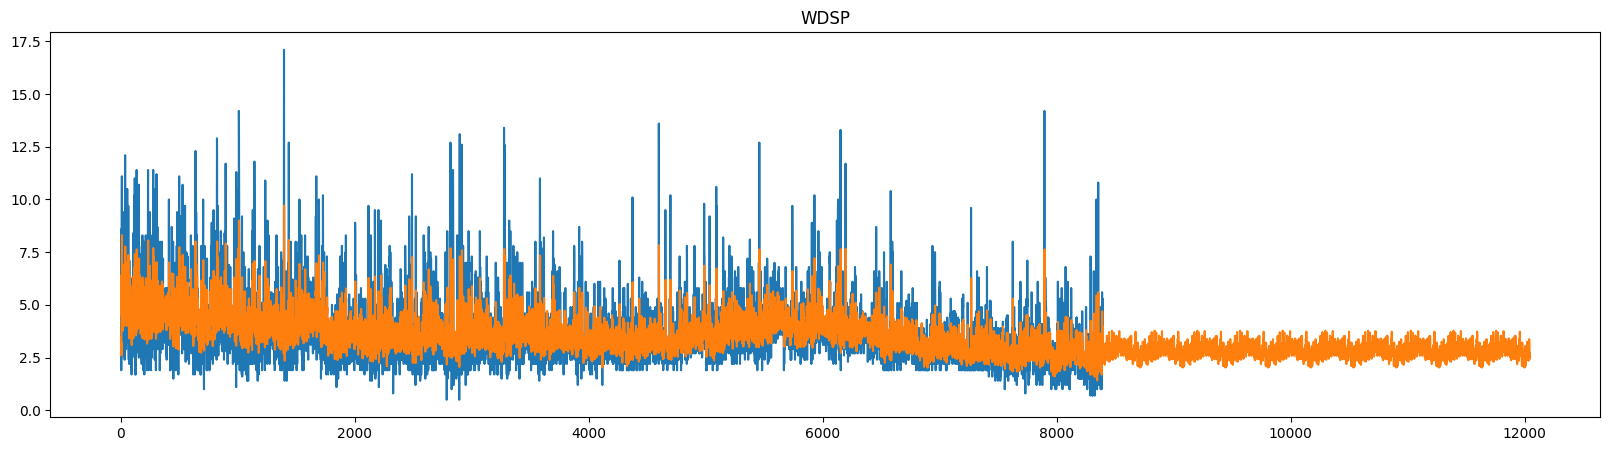

In [ ]:
print(predictions.shape)

unrolled_data = wm.year_data.reshape(-1, wm.year_data.shape[2]).T
print(unrolled_data.shape)
feature_names = ["MAX", "MIN", "TEMP", "MXSPD", "PRCP", "SLP", "DEWP", "WDSP"]
for i in range(len(predictions)):
    plt.figure(figsize=(20, 5))
    plt.title(feature_names[i])
    plt.plot(unrolled_data[i])
    plt.plot(predictions[i])
    plt.show()


food (217, 4)
Weather (217, 14)


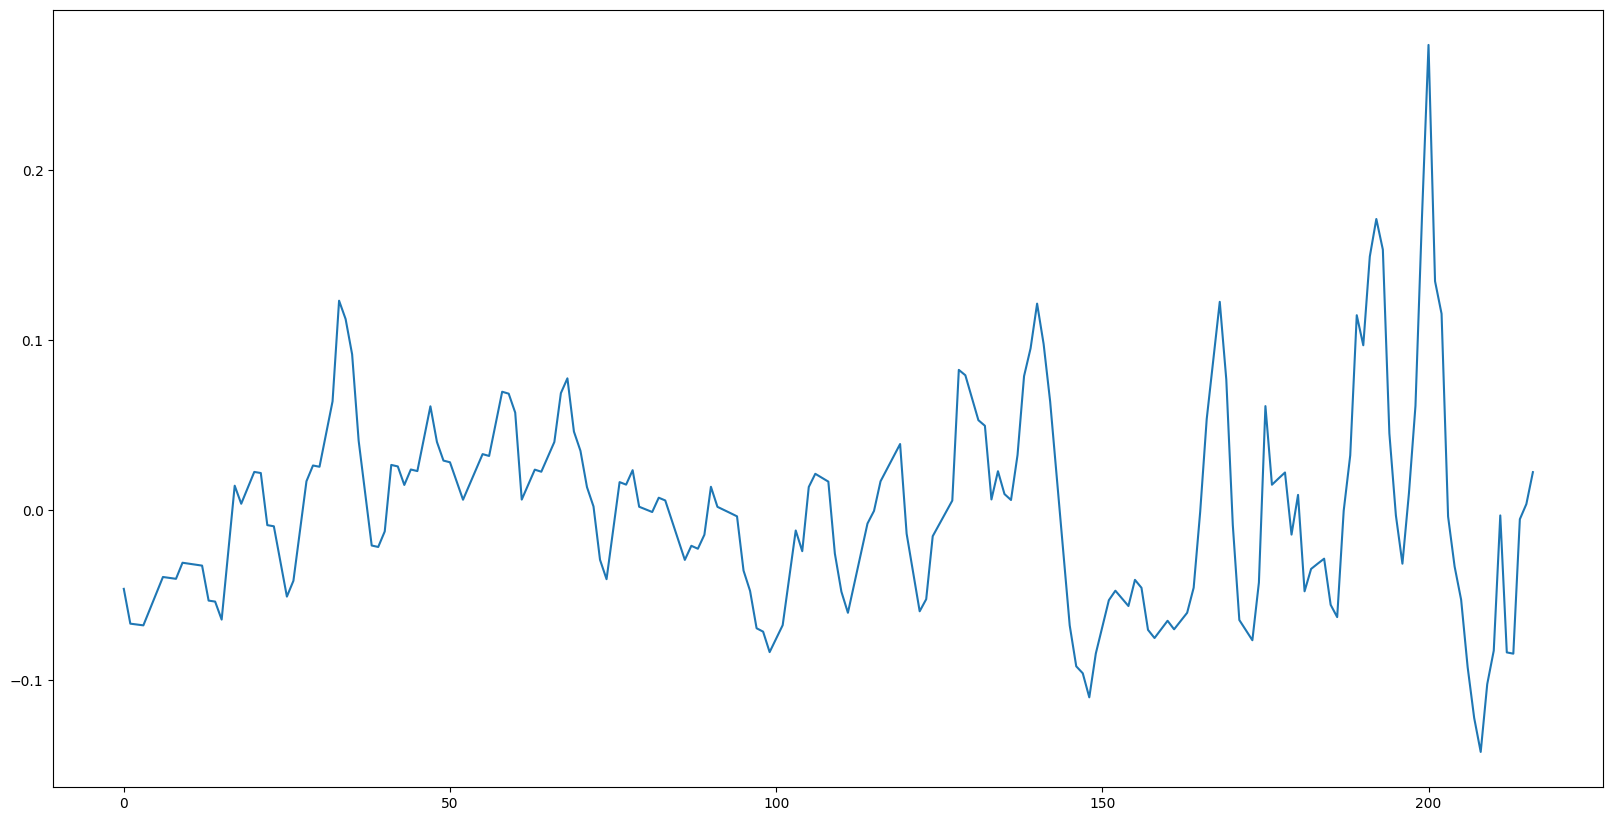

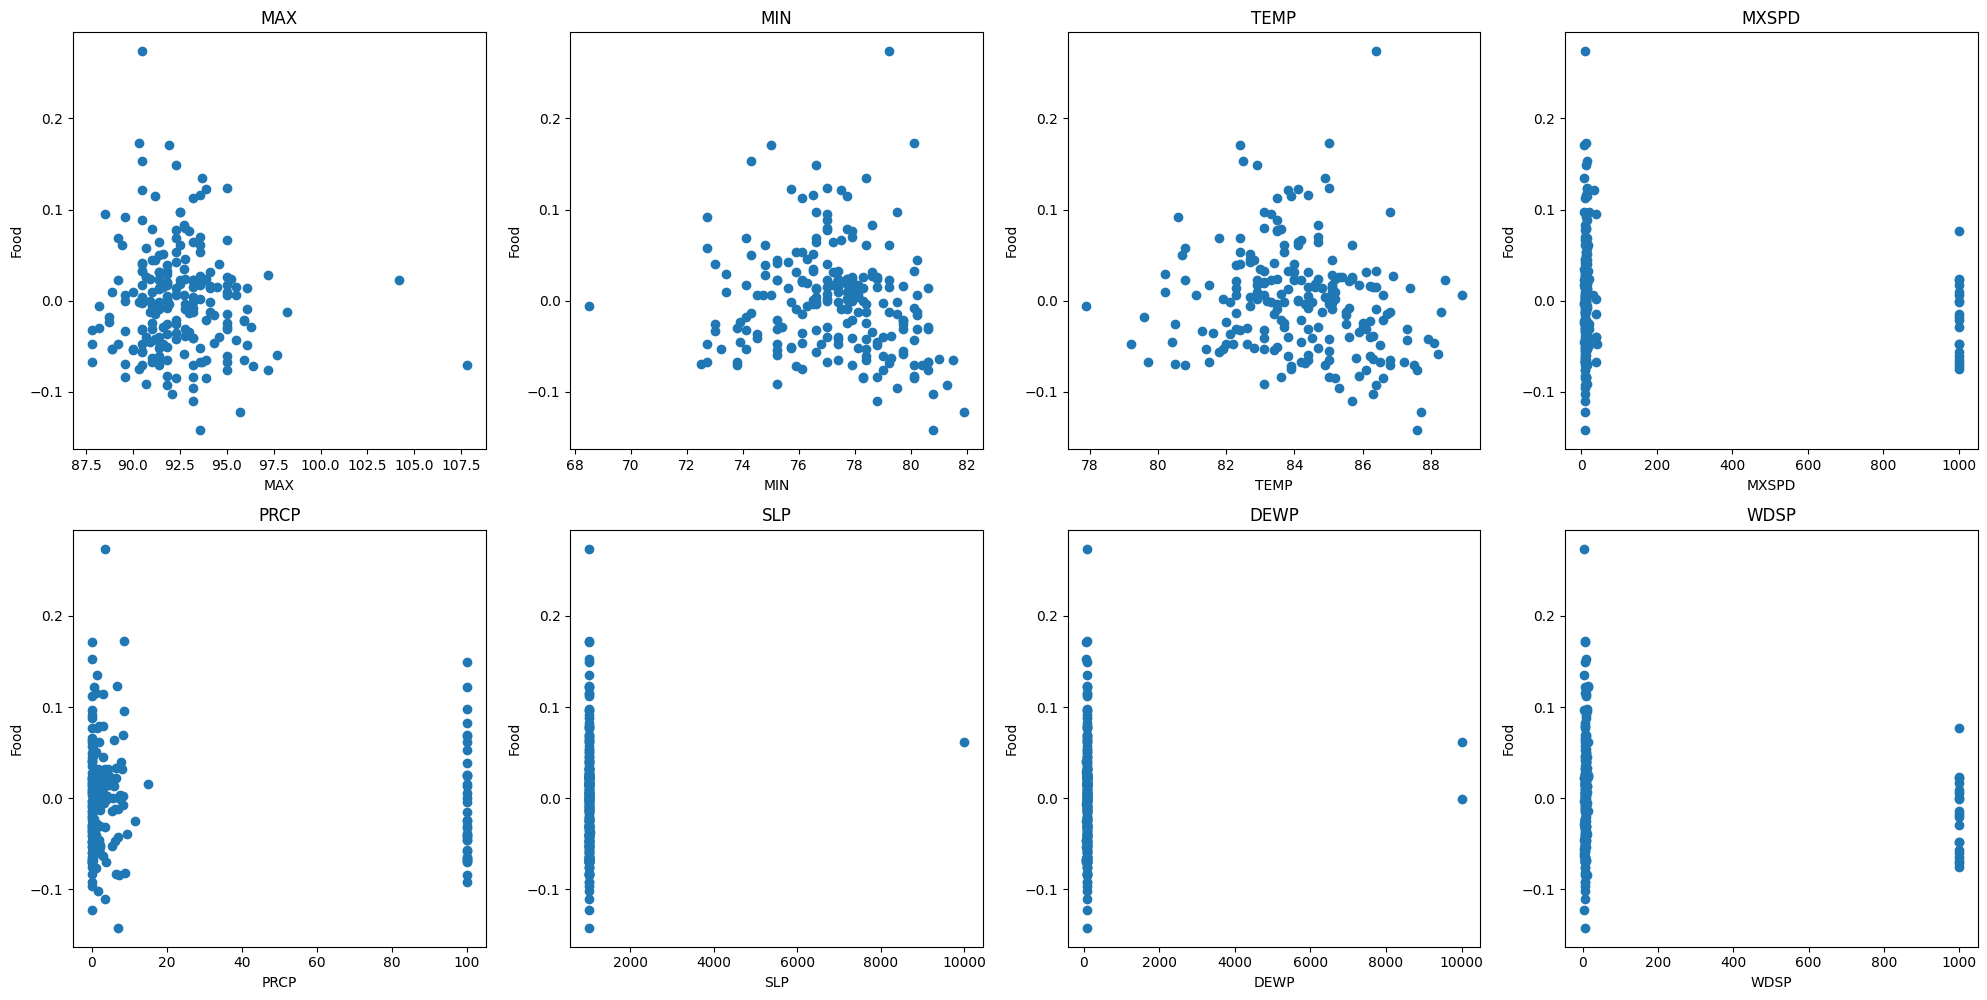

In [ ]:
#Plotting the scatter of feature vs food prioce for triend
unrolled_data = wm.year_data.reshape(-1, wm.year_data.shape[2]).T
feature_names = ["MAX", "MIN", "TEMP", "MXSPD", "PRCP", "SLP", "DEWP", "WDSP"]
weather = pd.read_csv('3968119.csv')
weather['DATE'] = pd.to_datetime(weather['DATE'])
weather = weather.set_index("DATE")
weather = weather.loc["2007":]
weather = weather.resample('M').max()
food = pd.read_csv("Ilocos_Sur_cleaned.csv")
food['Date'] = pd.to_datetime(food['Date'])
food = food.set_index("Date")
food = food.loc[: "2025-01-01"]
print("food",food.shape)
print("Weather",weather.shape)
plt.figure(figsize=(20, 10.1))


def exponential(x, a, b, c):
    return  a*b**x + c

x = np.arange(len(food))
y = food["Close"].values

popt, _ = curve_fit(exponential, x, y, p0=[1, 1, 1])


plt.plot(x,food["Close"] - exponential(x, *popt))
plt.show()

plt.figure(figsize=(20, 10.1))
for i in range(len(predictions)):
    plt.subplot(2,4,i+1)
    plt.title(feature_names[i])
    plt.scatter(weather[feature_names[i]], food["Close"] - exponential(x, *popt))
    plt.ylabel("Food")
    plt.xlabel(feature_names[i])

plt.tight_layout()
plt.show()


In [ ]:
class Combined_model:
    def __init__(self, features, labels,constants):
        self.features = features
        self.labels = labels

    def equation(self,constants):
        return np.abs(constants[0]*self.features[0]) + np.abs(constants[1]*self.features[1]) + np.abs(constants[2]*self.features[2]) + np.abs(constants[3]*self.features[3]) + np.abs(constants[4]*self.features[4])+ np.abs(constants[5]*self.features[5])+ np.abs(constants[6]*self.features[6])+ np.abs(constants[7]*self.features[7])
    
    def fit(self):
        x0 = np.ones(len(self.features))
        sol = minimize(self.equation, x0)
        return sol

In [ ]:
feature_names = ["MAX", "MIN", "TEMP", "MXSPD", "PRCP", "SLP", "DEWP", "WDSP"]

C = Combined_model(unrolled_data, feature_names, constants = np.ones(8))
